In [1]:
real_instrument_present = False

In [2]:
import numpy as np

from broadbean import Segment, SegmentGroup, Element, Sequence
from broadbean.atoms import sine, ramp, flat, zero, marker_on, marker_off
from broadbean.types import ForgedSequenceType
from broadbean.plotting import plotter
from broadbean.tools import check_sequence_duration_consistent


from qdev_wrappers.customised_instruments.sequencer import (ParametricSequencer, SimulatedAWGInterface, AWG5014Interface)
from qcodes import Instrument

C:\Users\a-dovoge\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:


if real_instrument_present:
    from qdev_wrappers.station_configurator import StationConfigurator
    sc = StationConfigurator()
    awg = sc.load_instrument('AWG5014')
    awg_int = AWG5014Interface(awg=awg)
else:
    awg_int = SimulatedAWGInterface()

In [4]:
seg1 = zero(duration='flex_time')
seg2 = flat(duration='pulse_duration', amplitude='pulse_amplitude')
seg3 = zero(duration='flex_time')

pi_pulse = SegmentGroup(seg1, seg2, seg3,
                        duration='total_duration')

m1 = marker_off(duration='pre_marker_time')
m2 = marker_on(duration='marker_time')
m3 = marker_off(duration='post_marker_time')

markers = SegmentGroup(m1, m2, m3,
                       duration='total_duration')

def mytransformation(context):
    context['flex_time'] = 0.5*(context['total_duration'] - context['pulse_duration'])
    context['pre_marker_time'] = context['flex_time'] + context['marker_delay']
    context['post_marker_time'] = context['total_duration'] - context['marker_time'] - context['pre_marker_time']

template_element = Element(segments={1: pi_pulse,
                                     2: pi_pulse,
                                     '1M2': markers},
                           sequencing={'nrep':2},
                           transformation=mytransformation)

ze = zero(duration='total_duration')
initial_element = Element(segments={1: ze,
                                    2: ze,
                                    '1M2': markers},
                          local_context={'pre_marker_time':5e-4,
                                         'marker_time':2e-4,
                                         'post_marker_time':5e-4,
                                         'total_duration':12e-4})


context = {'total_duration': 3e-3,
           'marker_time': 2e-4,
           'marker_delay': 5e-4,
           'pulse_duration': 0.5e-3,
           'pulse_amplitude': 1}

pulse_durations = np.linspace(0.5e-3,2.9e-3,3)

inner_setpoints = ('pulse_duration', pulse_durations)
outer_setpoints = ('pulse_amplitude', np.linspace(0.1,1,3))

setting repeated element to 2
setting repeated element to 2
uploading


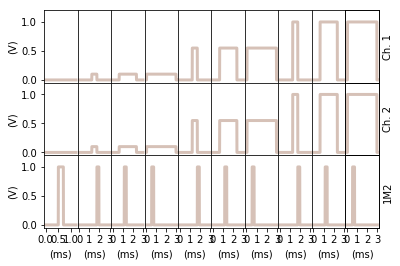

In [5]:
try:
    ps = Instrument.find_instrument('PS')
    ps.close()
except KeyError:
    pass
ps = ParametricSequencer(name='PS',
                         awg=awg_int,
                         template_element=template_element,
                         initial_element=initial_element,
                         context=context,
                         units={'pulse_duration':'s'},
                         labels={'pulse_duration':'Pulse Duration'},
                         inner_setpoints=inner_setpoints,
                         outer_setpoints=outer_setpoints)

uploading


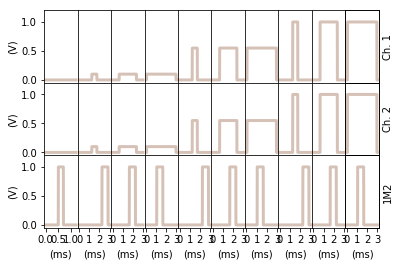

In [6]:
with ps.single_upload():
    ps.sequence.marker_delay(1e-3)
    ps.sequence.marker_time(6e-4)

setting repeated element to 2


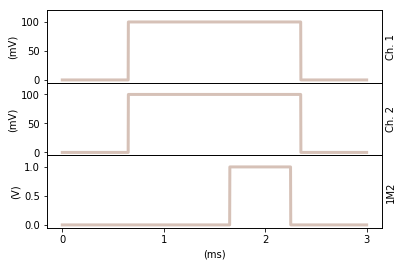

In [17]:
ps.repeat.pulse_duration(inner_setpoints[1][0])

setting repeated element to 5


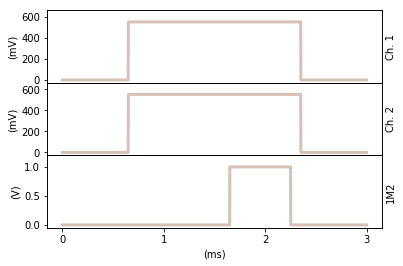

In [19]:
ps.repeat.pulse_amplitude(outer_setpoints[1][1])

In [8]:
ps._context

{'total_duration': 0.003,
 'marker_time': 0.0002,
 'marker_delay': 0.0,
 'pulse_duration': 0.0005}

In [44]:
ps.load_template()
ps.sequence.marker_time(1e-3)

with ps.single_upload():
    ps.sequence.marker_time(1e-2)
    ps.sequence.marker_delay(1e-3)
    
ps.set_setpoints(inner=('pulse_duration', pulse_durations), outer=(,))
ps.repeat_mode('inner')
ps.repeat_mode('sequence')
ps.repeat_mode('single')
ps.repeat.pulse_duration(1)

SyntaxError: invalid syntax (<ipython-input-44-d9b6585d4259>, line 13)

In [8]:
A = [1,2]
B = ()
list((x,y) for x in A for y in B)

[]

uploading


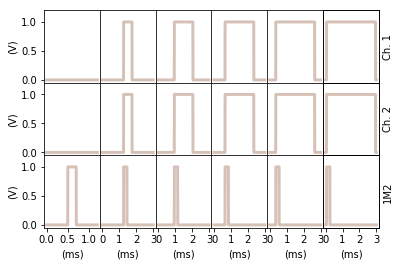

In [28]:
ps.marker_delay(0)

stepping from 5 to 2
stepping from 2 to 3
stepping from 3 to 4
stepping from 4 to 5


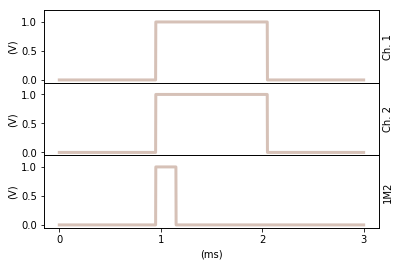

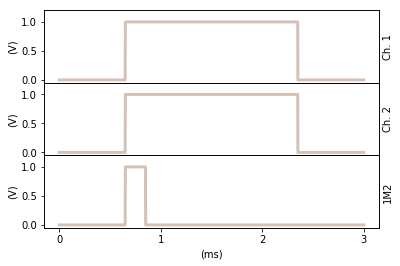

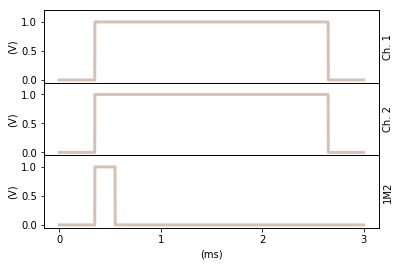

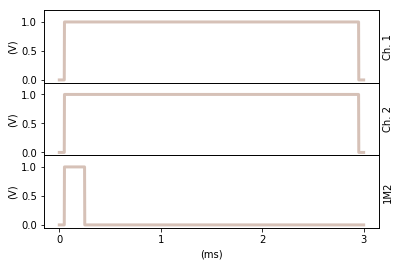

In [32]:
for i in range(4):
    ps.step_pulse_duration(pulse_durations[i])

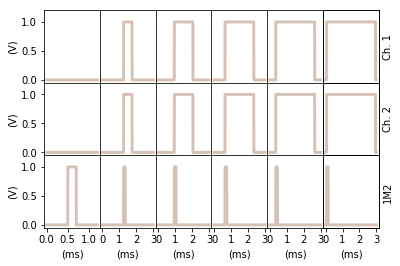

In [8]:
ps.marker_time(1e-4)

In [9]:
%debug

> c:\users\a-dovoge\repos\bb\broadbean\plotting.py(97)_plot_object_forger()
     95         seq = Sequence([elem])
     96     else:
---> 97         raise RuntimeError('Tried to plot object that is neither an element, sequence, segment nor a forged_sequence or forged_element. The argument was {obj_to_plot}')
     98 
     99     return seq.forge(**forger_kwargs)

ipdb> obj_to_plot
{'data': {1: array([0., 0., 0., ..., 0., 0., 0.]), 2: array([0., 0., 0., ..., 0., 0., 0.]), '1M2': array([0., 0., 0., ..., 0., 0., 0.])}, 'sequencing': {'nrep': 2}}
ipdb> forged_element_schema.validate(obj_to_plot)
{'data': {1: array([0., 0., 0., ..., 0., 0., 0.]), 2: array([0., 0., 0., ..., 0., 0., 0.]), '1M2': array([0., 0., 0., ..., 0., 0., 0.])}, 'sequencing': {'nrep': 2}}
ipdb> fs_schema.validate(obj_to_plot)
*** schema.SchemaUnexpectedTypeError: {'data': {1: array([0., 0., 0., ..., 0., 0., 0.]), 2: array([0., 0., 0., ..., 0., 0., 0.]), '1M2': array([0., 0., 0., ..., 0., 0., 0.])}, 'sequencing': {'nrep':

In [10]:
from broadbean.types import fs_schema
from schema import SchemaError
error = None
try:
    fs_schema.validate([1 ,2])
except SchemaError as e:
    error = e
    

In [14]:
error

schema.SchemaError("Or({'data': Or([{'data': {Or(<class 'str'>, <class 'int'>): <class 'numpy.ndarray'>}, 'sequencing': {Optional(<class 'str'>): <class 'int'>}}], {Or(<class 'str'>, <class 'int'>): <class 'numpy.ndarray'>}), 'sequencing': {Optional(<class 'str'>): <class 'int'>}}) did not validate 1\n1 should be instance of 'dict'")

In [30]:
a = template_element.forge(SR=1, context={'nothing':0}, meta_data_only=True)

KeyError: 'total_duration'

In [6]:
a

{1: {'atom': 'zero', 'args': {'duration': 0.0012}},
 2: {'atom': 'zero', 'args': {'duration': 0.0012}},
 '2M2': ({'atom': 'off', 'args': {'duration': 0.0005}},
  {'atom': 'on', 'args': {'duration': 0.0002}},
  {'atom': 'off', 'args': {'duration': 0.0005}})}